# Introduction

Theragun produces various kind of Health and Wellness products and they have hired us to help in their recent Online marketing campaign. They are interested in placing their ads via Google Adsense and other platforms specifically on the Articles cenetered around Health and related Wellness topics. Their goal is to identify as many such articles as possible.

To fulfil this need we have created a Deep Learning Model based on pretrained DistilBERT model availaible via K-Train wrapper in Tensorflow.

<b> Note: While the course required the work in Google Colab, due to Colab restrictions GPU was not availaible for more than 2 days in free mode as even the checking of learning rate exhausted the free quota, and since dedicated Nvidia GPUs were availaible model was trained on an 8 GB RTX 4060 Mobile GPU with 135 Watt Power limit. This fact should be considered if work here is reproduced as it will effect the time taken for all the process and most importantly smaller batch sizes to run on 8 GB VRAM. <b>

## Imports

We're going to be using Google's Tensorflow package:
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called ktrain. It's absolutely fabulous because it really abstracts the whole deep learning process into an easy workflow by abstracting a lot of complext Language modelling elements:
https://github.com/amaiya/ktrain

In [1]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
from ktrain import text
from ktrain.text import texts_from_df
import time
import pandas as pd
from keras.preprocessing.text import Tokenizer
import pickle
import json
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

2024-03-04 18:00:09.285556: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 18:00:09.308377: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 18:00:09.308408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 18:00:09.308422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 18:00:09.313351: I tensorflow/core/platform/cpu_feature_g

2.14.0


/home/anubh/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from google.colab import drive #necessary code if data is stored in Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## It is recommended to switch to GPU beyond this point if running on Colab
Runtime > Change Runtime Type > GPU

Let's download our data. For this project, we're going to be using data from Kaggle.

https://www.kaggle.com/rmisra/news-category-dataset/version/2

However the course provided Json file instead of Jsonl availaible in Kaggle for easier access to the data. Same can be downloaded via course or at the sharable drive link given below, until it is active.

https://drive.google.com/file/d/1eNX_srjI8BC5y7GDQAxwG_-NK8hNvRjV/view?usp=drive_link

Following code was used to transform the jsonl file. It may take time but reader can try it themselves.

```
json_file = open('News_Category_Dataset_v2.json', 'r')
columns = ['category', 'headline', 'authors', 'link', 'short_description', 'date']

training_data = pd.DataFrame(columns = columns)

for i, aline in enumerate(json_file):
  parsed_json = json.loads(aline)
  for acolumn in columns:
    training_data = training_data.append(pd.Series(name=i, dtype='float64'))
    training_data[acolumn][i] = parsed_json[acolumn]
  if i % 1000 == 0:
      print(i)
```



Note: Directory file paths need to be adjusted if this notebook is being run locally or on Colab depending on the file location.

In [5]:
reviews = pd.read_json('news_category_training_data.json') #dataset slightly renamed to have a common naming scheme

## Preparing the Data

In [6]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [7]:
reviews['category'].value_counts(normalize = True)

category
POLITICS          0.163000
WELLNESS          0.088756
ENTERTAINMENT     0.079949
TRAVEL            0.049225
STYLE & BEAUTY    0.048040
PARENTING         0.043201
HEALTHY LIVING    0.033328
QUEER VOICES      0.031436
FOOD & DRINK      0.030998
BUSINESS          0.029559
COMEDY            0.025765
SPORTS            0.024316
BLACK VOICES      0.022544
HOME & LIVING     0.020886
PARENTS           0.019691
THE WORLDPOST     0.018242
WEDDINGS          0.018177
WOMEN             0.017376
IMPACT            0.017222
DIVORCE           0.017057
CRIME             0.016953
MEDIA             0.014015
WEIRD NEWS        0.013293
GREEN             0.013054
WORLDPOST         0.012840
RELIGION          0.012726
STYLE             0.011222
SCIENCE           0.010844
WORLD NEWS        0.010839
TASTE             0.010435
TECH              0.010366
MONEY             0.008499
ARTS              0.007513
FIFTY             0.006975
GOOD NEWS         0.006960
ARTS & CULTURE    0.006667
ENVIRONMENT       0

In [8]:
reviews.shape

(200853, 6)

We have 200,853 articles in total with 24,521 articles about Wellness or Healthy Living categories. While they are our target articles, we have highly unbalanced dataset with around 12% articles contianing our target categories.

To solve this issue we will create a training dataset which has equal number of articles for both Healthy/Wellness and Not Healthy/Wellness.

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [9]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

Since we are interested in 2 categories we need a new Target Variable which will have 1 when either of the 2 categories, that is Healthy Living and Wellness, appear and 0 otherwise.

In [10]:
reviews[reviews['category'].str.contains("HEALTHY LIVING" or "WELLNESS")]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
124913,HEALTHY LIVING,Why You Need Both a 'Bouncer' and a 'Bartender...,"Elizabeth Grace Saunders, ContributorFounder, ...",https://www.huffingtonpost.com/entry/happy-hea...,Instead of judging whether you made the right ...,2014-04-18,Why You Need Both a 'Bouncer' and a 'Bartender...
124914,HEALTHY LIVING,How Video Games Can Improve Dialogue on Mental...,"Mona Shattell, Contributornurse researcher",https://www.huffingtonpost.com/entry/mental-il...,While there are strong arguments for the games...,2014-04-18,How Video Games Can Improve Dialogue on Mental...
124925,HEALTHY LIVING,Wake-Up Calls Inspired My Change From Overdriv...,"Jane Shure, ContributorLeadership Coach, Psych...",https://www.huffingtonpost.com/entry/wake-up-c...,My wake-up call marching orders were clear: No...,2014-04-18,Wake-Up Calls Inspired My Change From Overdriv...
124950,HEALTHY LIVING,Loving a Narcissist Without Losing Yourself,"Nancy Colier, ContributorPsychotherapist, inte...",https://www.huffingtonpost.com/entry/narcissis...,It is very difficult for some people to see an...,2014-04-18,Loving a Narcissist Without Losing Yourself It...


In [11]:
reviews['healthy/wellness'] = np.where((reviews['category'] == 'HEALTHY LIVING') | (reviews['category'] == 'WELLNESS'), 1, 0)

In [12]:
((reviews['category'] == 'HEALTHY LIVING') | (reviews['category'] == 'WELLNESS')).sum()

24521

In [13]:
reviews['healthy/wellness'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy/wellness, dtype: float64

(array([176332.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  24521.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

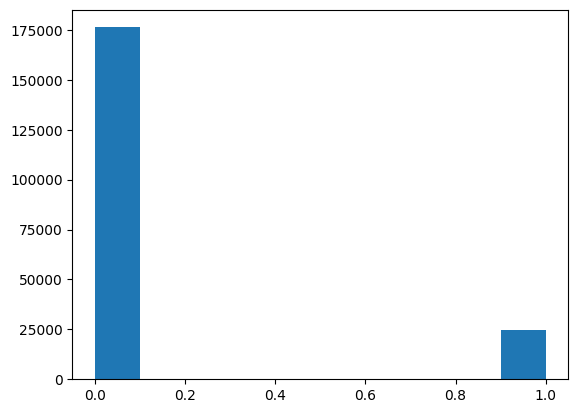

In [24]:
plt.hist(reviews['healthy/wellness'])

A basic plot showing the difference in positive and negative examples in this unbalanced dataset.

In [14]:
sample_amount = len(reviews[reviews["healthy/wellness"] == 1])

healthy = reviews[reviews['healthy/wellness'] == 1]
not_healthy = reviews[reviews['healthy/wellness'] == 0].sample(n=sample_amount, random_state = 10)

In [15]:
review_sample = pd.concat([healthy,not_healthy])

In [16]:
review_sample.describe()

,date,healthy/wellness
count,49042,49042.000000
mean,2014-08-06 01:59:14.487990016,0.500000
min,2012-01-28 00:00:00,0.000000
25%,2013-02-24 00:00:00,0.000000
50%,2014-03-12 00:00:00,0.500000
75%,2015-12-19 00:00:00,1.000000
max,2018-05-26 00:00:00,1.000000
std,NaN,0.500005


A mean of 0.5 means these datasets are now perfectly balanced. And the N = 2*24521!

## Test, Tune and Save Models

In [17]:
target_names = ['NOT HEALTHY LIVING/WELLNESS','HEALTHY LIVING/WELLNESS']

In [18]:
#tf.keras.backend.clear_session()
t = text.Transformer('distilbert-base-uncased', maxlen=512, class_names=target_names)
# #other models you might try 'roberta-base', 'bert-base-uncased', 'distilroberta-base'
#we're going to use 'distilbert-base-uncased' for our model here
#ktrain lets us try some of the pretrained models available on huggingface
#you can browse all the models here: https://huggingface.co/transformers/pretrained_models.html
#some work, some dont, try at your own risk.

2024-03-04 18:01:35.256739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 18:01:35.357004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 18:01:35.357056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 18:01:35.360196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 18:01:35.360606: I tensorflow/compile

We have tested roberta-base and distilbert-base, both produces similar result on the dataset and hence distilbert-base was chosen because it was a bit easier to train on the 8 GB VRAM GPU.

In [19]:
train, val, preprocess = texts_from_df(review_sample, 'combined_text', label_columns=['healthy/wellness'], val_df=None, max_features=20000, maxlen=512, val_pct=0.1, ngram_range=1, preprocess_mode='distilbert', verbose=1)

['not_healthy/wellness', 'healthy/wellness']
        not_healthy/wellness  healthy/wellness
144387                   0.0               1.0
59884                    1.0               0.0
165889                   1.0               0.0
50399                    1.0               0.0
200559                   0.0               1.0
['not_healthy/wellness', 'healthy/wellness']
        not_healthy/wellness  healthy/wellness
17899                    1.0               0.0
182469                   1.0               0.0
180164                   0.0               1.0
132451                   1.0               0.0
88838                    0.0               1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 33
	95percentile : 59
	99percentile : 68


### Hyperparameter Tuning

For hyperparameter tuning we have focused on the learning rate, epochs, and batch size.

Learning Rate was tested based on the lr_find. The learning rate of 0.0001 was found to be best one for validation loss as it helped the models in 1 epoch only with lowest validation loss.

Epochs was chosen to be 12 but we also used early stopping to stop overfitting the model with training data.

Various kinds of Batch Sizes were tested. We tested 16, 12, 10, 8, and 4. For the model below batch size of 8 provided the best balance due to limited VRAM.

In [22]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data = train, val_data = val, batch_size = 8)

In [53]:
#Uncomment this section to check for Hyperparameter tuning. This code alone was enough to completely exhaust the Colab resources 
#as each epoch took more than 50 minutes. We found learning rate = 0.0004 as most optimal for our model and it was able to get best model 
# in 1 epoch only

#learner.lr_find(max_epochs = 4)
#learner.lr_plot()

In [23]:
history=learner.autofit(lr = 0.0001, checkpoint_folder='checkpoint', epochs=12, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
5518/5518 [==============================] - 1826s 329ms/step - loss: 0.2594 - accuracy: 0.8975 - val_loss: 0.2300 - val_accuracy: 0.9101
Epoch 2/12
5518/5518 [==============================] - 1812s 328ms/step - loss: 0.1736 - accuracy: 0.9368 - val_loss: 0.2392 - val_accuracy: 0.9119
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


We can train the model more and get even lower training accuracy but our validation loss is increasing, leading to an early stopping.

In [25]:
learner.save_model("Models") #kindly change the path name for saving the model as required

In [26]:
predictor = ktrain.get_predictor(learner.model, preproc = preprocess) #kindly change the path name for saving the predictor as required
predictor.save("Models/distilbertmodel_predictor")

In [28]:
validation = learner.validate(val_data=val, print_report=True)

154/154 [==============================] - 29s 185ms/step
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      2447
           1       0.90      0.93      0.91      2458

    accuracy                           0.91      4905
   macro avg       0.91      0.91      0.91      4905
weighted avg       0.91      0.91      0.91      4905



2024-03-04 19:08:42.232525: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 14223035841211147212
2024-03-04 19:08:42.232567: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16383104163609519266
2024-03-04 19:08:42.232574: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10001081610313711625
2024-03-04 19:08:42.232593: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17566559741852055733


We got a very competitive model with a few lines of code due to Ktrain. We will focus on accuracy here because model is balanced.

With the accuracy of 0.91 on validation dataset this model is better than others created during the course. And also it has a good recall of 0.93 for the Positive Articles, meaning that it was able to flag 93% of all Healthy/Wellbeing articles. This can surely help the Threagun in placing the digital ads across correct targetted articles. 

# Further Analysis

At this step we will further analyze the model.

Let's go ahead and make a little set of test documents to check out

In [30]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [96]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy/wellness is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy/wellness is 0.9920129
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy/wellness is 0.98869216
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy/wellness is 0.9475943
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy/wellness is 0.9495482
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy/wellness is 0.0021799286
Cuomo Will Not Be Prose

Model is correctly predicting the test article with relatively high probability attached to the correct articles, all above 0.94.

In [39]:
predictor.predict('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.', return_proba = True)

array([0.33241376, 0.6675862 ], dtype=float32)

However, it is far from perfect. As we can see here the description here contains, healthy society among other things which could contain weight in model even if description is not about an Health or Wellness based article. Our model flagged it as Healthy/Wellness with probability of 0.667. This is an improvement if we compare to previous models having 0.74 peobability. We can adjust the cutoff to greater than 0.7 or so.

We can also try to increase the examples of negative examples so that model can learn from them. We will do it in the next step

## Unbalanced Dataset Based Model

In this step we will train another DistilBERT model with twice the number of negative examples and check if it improves at identifying more complex articles correctly. 

In [43]:
sample_amount_2 = len(reviews[reviews["healthy/wellness"] == 1])*2

healthy = reviews[reviews['healthy/wellness'] == 1]
not_healthy = reviews[reviews['healthy/wellness'] == 0].sample(n=sample_amount_2, random_state = 10)

In [45]:
review_sample_2 = pd.concat([healthy,not_healthy])

In [46]:
review_sample_2.describe()

,date,healthy/wellness
count,73563,73563.000000
mean,2014-10-24 22:22:34.496146176,0.333333
min,2012-01-28 00:00:00,0.000000
25%,2013-04-17 00:00:00,0.000000
50%,2014-07-26 00:00:00,0.000000
75%,2016-04-21 00:00:00,1.000000
max,2018-05-26 00:00:00,1.000000
std,NaN,0.471408


One Third of the observations in this dataset are positive examples while rest are negative examples.

In [47]:
train_2, val_2, preprocess_2 = texts_from_df(review_sample_2, 'combined_text', label_columns=['healthy/wellness'], val_df=None, max_features=20000, maxlen=512, val_pct=0.1, ngram_range=1, preprocess_mode='distilbert', verbose=1)`x

['not_healthy/wellness', 'healthy/wellness']
        not_healthy/wellness  healthy/wellness
80089                    1.0               0.0
197519                   1.0               0.0
180658                   1.0               0.0
106952                   0.0               1.0
95492                    0.0               1.0
['not_healthy/wellness', 'healthy/wellness']
        not_healthy/wellness  healthy/wellness
88171                    1.0               0.0
67976                    1.0               0.0
84052                    1.0               0.0
137647                   0.0               1.0
89909                    1.0               0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 31
	95percentile : 57
	99percentile : 67


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 31
	95percentile : 57
	99percentile : 67


We have done similar hyperparameter tuning for this model too. Once again learnning rate of 0.0001 was found to be best option. For Batch Size we were able to train with only batch size of 4 or lower. If more VRAM is availaible this can be increased accordingly.

In [50]:
model_2 = preprocess.get_classifier()
learner_2 = ktrain.get_learner(model_2, train_data = train_2, val_data = val_2, batch_size=4)

In [51]:
history_2 = learner_2.autofit(lr = 0.0001, checkpoint_folder='checkpoint', epochs=12, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
16552/16552 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8795

2024-03-04 20:07:14.337215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:175: Filling up shuffle buffer (this may take a while): 42567 of 66206
2024-03-04 20:07:19.408960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


16552/16552 [==============================] - 2868s 172ms/step - loss: 0.2966 - accuracy: 0.8795 - val_loss: 0.2299 - val_accuracy: 0.9123
Epoch 2/12
16552/16552 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.8365

2024-03-04 20:54:37.955300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:175: Filling up shuffle buffer (this may take a while): 59629 of 66206
2024-03-04 20:54:39.119455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Restoring model weights from the end of the best epoch: 1.
16552/16552 [==============================] - 2841s 172ms/step - loss: 0.3333 - accuracy: 0.8365 - val_loss: 0.4572 - val_accuracy: 0.7091
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [54]:
predictor_2 = ktrain.get_predictor(learner_2.model, preproc = preprocess_2)

In [87]:
validation_2 = learner_2.validate(val_data = val_2, print_report=True)

230/230 [==============================] - 42s 184ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      4893
           1       0.86      0.88      0.87      2464

    accuracy                           0.91      7357
   macro avg       0.90      0.90      0.90      7357
weighted avg       0.91      0.91      0.91      7357



2024-03-04 23:08:02.009435: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8407797739455120991
2024-03-04 23:08:02.009488: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16444579926754923838
2024-03-04 23:08:02.009517: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 628853751392318912


Validation Accuracy is similar with 0.91, however this Model is using unbalanced dataset so we will focus on Recall and precision, more specifically on the recall.

For Negative Examples new Model has both higher precision and recall compared to model. However we can also observe lower Recall and Precision for Positive Examples, which is a matter of concern. While new model is progressively better in flagging negative examples, due to lower propertion or lower number of positive observations we see a reduction in recall and precision for that part. 

In [95]:
for i, text in enumerate(test_docs):
  probs = predictor_2.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy/wellness is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy/wellness is 0.9489601
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy/wellness is 0.933506
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy/wellness is 0.9437348
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy/wellness is 0.9376104
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy/wellness is 0.02031795
Cuomo Will Not Be Prosecute

In [58]:
predictor_2.predict('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.', return_proba = True)

array([0.3416929 , 0.65830714], dtype=float32)

There is not much difference in the performance across the models in the complex example we used before as previously we got 0.667 probability for Healthy/Wellness and this time we have probability of 0.658, not much of a difference.

However, it is not the complete picture. This example was specifically created to test the model, now we will find few similar complex articles from internet randomly and test them.

In [89]:
test_complex = [
    "The United States health care system is on a collision course with demographic trends and economic realities. In its May 2008 issue, the health policy journal Health Affairs predicted that “if current trends persist, sometime between 2016 and 2020 existing federal revenues will cover only health entitlements, Social Security, debt service, and a smaller defense budget, leaving nothing for anything else, including the environment, education or new health initiatives.",
    "The main objective of this study is to examine the effect of health on economic growth based on 719 estimates obtained from 64 studies from all over the world. We find evidence of a publication bias towards a positive estimated effect of health on economic growth. After accounting for heterogeneity of the estimates, we show that health has a genuine positive effect on economic growth. Less developed countries seem to enjoy a higher effect of health on growth driven by the ongoing economic–demographic transition in those countries.",
    "Poor mental health can make earning and managing money harder. And worrying about money can make your mental health worse. It can start to feel like a vicious cycle. Here, you can find out more about organising your finances, claiming benefits when you have a mental health problem, dealing with services, and looking after your mental health when you’re worried about money.",
    "High exposure to ultra-processed foods like sodas, candy, pre-packaged meat, sugary cereals, and potato chips is connected to an increased risk of 32 health issues including cancer, cardiovascular, gastrointestinal, and respiratory disorders, depression, anxiety, and early death, according to a new study published in The BMJTrusted",
    "In the Global Wellness Institute’s latest Global Wellness Economy Monitor report, now in its fifth edition, researchers at the organization said the wellness economy reached a global total of $5.6 trillion in 2022 with a compounded annual growth rate of 12.1 percent. The sectors include spas, thermal/mineral springs, wellness tourism,"
]

In [94]:
for i, text in enumerate(test_complex):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy/wellness is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy/wellness is 0.6713605
The United States health care system is on a collision course with demographic trends and economic realities. In its May 2008 issue, the health policy journal Health Affairs predicted that “if current trends persist, sometime between 2016 and 2020 existing federal revenues will cover only health entitlements, Social Security, debt service, and a smaller defense budget, leaving nothing for anything else, including the environment, education or new health initiatives.
---------------------------
The probability this is healthy/wellness is 0.81019896
The main objective of this study is to examine the effect of health on economic growth based on 719 estimates obtained from 64 studies from all over the world. We find evidence of a publication bias towards a positive estimated effect of health on economic growth. After accounting for heterogeneity of the estimates, we show that health has a genuine positive eff

In [93]:
for i, text in enumerate(test_complex):
  probs = predictor_2.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy/wellness is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy/wellness is 0.41782078
The United States health care system is on a collision course with demographic trends and economic realities. In its May 2008 issue, the health policy journal Health Affairs predicted that “if current trends persist, sometime between 2016 and 2020 existing federal revenues will cover only health entitlements, Social Security, debt service, and a smaller defense budget, leaving nothing for anything else, including the environment, education or new health initiatives.
---------------------------
The probability this is healthy/wellness is 0.83476603
The main objective of this study is to examine the effect of health on economic growth based on 719 estimates obtained from 64 studies from all over the world. We find evidence of a publication bias towards a positive estimated effect of health on economic growth. After accounting for heterogeneity of the estimates, we show that health has a genuine positive ef

Among the 5 examples, only fourth article caters to healthy/wellness specifically. Last article is about Wellness industry as a whole so it can be flagged as such, similarly third article is about mental health around financial aspects, both can be flagged as healthy or wellness based articles with some relaxations. However first and second articles are definitely not based on these topics.

Here we have some interesting findings:
1. New model with more negative observations was able to successfully avoid flagging first one as healthy/wellness with probability of 0.418 against  0.67 from previous model. This reflects that in some cases new models trained on more negative examples could help us.
2. Both models are still mostly focused on few keywords like Health, mental health, and more. Due to this even if Second model was able to identify first article properly it failed in second article.
3. Still, new model is able to learn more complex representations. Both first and last article has difference more than 0.2 in predicting healthy/wellness articles, while first was definitely is not such an article, last one is about the Wellness Industry and generally is not catering to the target audience of Theragun as it was posted on a Financial Website.

Overall, model with more negative example seems to have learned more complex representaations across different words even if we have lower recall for the Positive Examples. We cam improve the model further with more training data, more positive data while keeping current propertion of 2:1 or opting for 3:1, higher propertion for Negative examples and lesser for the positive examples. We can also try more complex models on more powerful computing resources.